In [1]:
from tf_activation.models import mnist_cff as mnist_model

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import itertools
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
GRAPH_LOC = '../logdir/data/graphs'
SAVE_PATH = '../logdir/models'
RESULT_PATH = '../logdir/data/experiments/cluster_mnist'
ADV_TYPE = 'carlini_attacks_targeted500.99'
ADV_SET = 'adversaries/' + ADV_TYPE
ADV_IMAGES = '../logdir/adversaries/' + ADV_TYPE
model = 'mnist_cff50.ckpt'
graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f)) and int(f[2:f.find('.')]) < 50]
adv_graphmls = [f for f in listdir(join(GRAPH_LOC, ADV_SET)) if isfile(join(GRAPH_LOC, ADV_SET, f))]
MAX_STEPS = 50

def get_matchings(x_list, y_list):
    ret = []
    for x in x_list:
        if y_list.isin([x]).any():
            ret.append(x)
    return ret

def average_sim(df):
    s = 0
    for col in df.columns:
        s += df[col].dropna().shape[0]
    return s/len(df.columns)

In [3]:
df = []
files = []
with tf.device('/cpu:0'):
        # Create the model
        x = tf.placeholder(tf.float32, [None, 784])

        # Define loss and optimizer
        y_ = tf.placeholder(tf.float32, [None, 10])

        # Build the graph for the deep net
        net, keep_prob = mnist_model.deepnn(x)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        
with tf.Session() as sess:
    
    saver.restore(sess, os.path.join(SAVE_PATH, model))
    
    for f in graphmls:
        print(f)
        files.append(f)
        i = int(f[2:f.find('.')])
        col = {}
        g1 = nx.read_graphml(join(GRAPH_LOC, f)).to_undirected()
        g = nx.Graph()
        for e1, e2, data in g1.edges(data=True):
            g.add_edge(e1, e2, weight=data['weight'])
        col['number_connected_components'] = nx.number_connected_components(g)
        col['average_node_connectivity'] = nx.average_node_connectivity(g)
        
        test_inputs = np.stack((mnist.train.images[i], mnist.train.images[i]))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        col['adversary'] = False
        col['predicted_class'] = np.argmax(y_conv)
        col['file'] = f
        col['correct'] = np.argmax(mnist.train.labels[i])
        
        df.append(col)
    steps = 0
    for f in adv_graphmls:
        print(f)
        files.append(f)
        i = int(f[4:f.find('.')])
        col = {}
        g1 = nx.read_graphml(join(GRAPH_LOC, ADV_SET, f)).to_undirected()
        g = nx.Graph()
        for e1, e2, data in g1.edges(data=True):
            g.add_edge(e1, e2, weight=data['weight'])
        col['number_connected_components'] = nx.number_connected_components(g)
        col['average_node_connectivity'] = nx.average_node_connectivity(g)
        
        adv_im = np.genfromtxt(join(ADV_IMAGES, f[:f.find('.')] + '.csv'), delimiter=',')
        
        test_inputs = np.stack((adv_im, adv_im))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        col['adversary'] = True
        col['predicted_class'] = np.argmax(y_conv)
        col['file'] = f
        col['correct'] = np.argmax(mnist.train.labels[i])
        
        df.append(col)
        
        steps += 1
        if steps > MAX_STEPS:
            break
        
df = pd.DataFrame(df)

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff50.ckpt
4_2.graphml
1_12.graphml
7_49.graphml
9_45.graphml
8_9.graphml
2_13.graphml
6_40.graphml
6_39.graphml
0_15.graphml
7_14.graphml
4_47.graphml
3_31.graphml
1_23.graphml
9_17.graphml
8_34.graphml
5_28.graphml
6_3.graphml
9_8.graphml
8_29.graphml
0_7.graphml
6_26.graphml
3_1.graphml
6_37.graphml
1_20.graphml
4_46.graphml
9_24.graphml
0_10.graphml
8_5.graphml
7_25.graphml
1_6.graphml
6_21.graphml
9_44.graphml
8_30.graphml
0_48.graphml
7_22.graphml
8_43.graphml
4_38.graphml
7_0.graphml
4_33.graphml
5_27.graphml
3_41.graphml
3_36.graphml
8_42.graphml
7_35.graphml
3_11.graphml
0_19.graphml
1_4.graphml
6_18.graphml
4_32.graphml
0_2_3.graphml
9_0_7.graphml
3_4_30.graphml
7_2_0.graphml
7_0_26.graphml
1_8_5.graphml
1_0_5.graphml
5_3_45.graphml
2_4_38.graphml
7_2_26.graphml
1_3_46.graphml
0_4_28.graphml
1_3_40.graphml
5_0_23.graphml
5_7_23.graphml
2_3_35.graphml
3_0_32.graphml
1_4_40.graphml
6_0_21.graphml
4_8_19.graphml
7_

In [4]:
df.head()

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
0,1.0,False,0.130179,4,1.468234e-02,4_2.graphml,8,4,0.510284
1,1.0,False,0.647177,1,0.000000e+00,1_12.graphml,2,1,0.778228
2,1.0,False,1.000000,7,0.000000e+00,7_49.graphml,1,7,0.697406
3,1.0,False,0.136799,9,4.768370e-07,9_45.graphml,8,9,0.703297
4,1.0,False,0.121139,8,0.000000e+00,8_9.graphml,10,8,0.675188


In [5]:
df.sort_values(by='average_node_connectivity', axis=0, ascending=False)

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
8,1.0,False,1.177047,0,0.000000e+00,0_15.graphml,1,0,0.850613
23,1.0,False,1.109822,1,1.192093e-07,1_20.graphml,1,1,0.789872
66,0.0,True,1.072803,6,7.826372e+00,1_4_40.graphml,1,1,-0.106910
88,0.0,True,1.068832,3,3.802420e+00,1_0_31.graphml,1,1,-0.144317
82,0.0,True,1.066999,8,7.629438e+00,1_2_5.graphml,3,1,0.031594
91,0.0,True,1.007175,6,7.433364e+00,1_0_37.graphml,2,1,-0.608930
45,1.0,False,1.000000,0,0.000000e+00,0_19.graphml,1,0,0.801463
2,1.0,False,1.000000,7,0.000000e+00,7_49.graphml,1,7,0.697406
94,0.0,True,0.972409,6,5.828609e+00,1_5_39.graphml,5,1,-0.025826
80,0.0,True,0.953347,6,8.316620e+00,7_1_26.graphml,6,7,-0.659504


In [6]:
df.to_pickle('../logdir/data/experiments/subgraph_algo_analysis_targeted500_99.pkl')

In [7]:
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.externals import joblib
def regress(X, y, xlab, ylab, color_vals='b'):

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))

    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs

    ax.scatter(X, y,  color=color_vals)
#     ax.plot(X, regr.predict(X), color='silver', linewidth=3)
#     ax.set_xlim(X_min, X_max)
#     ax.set_ylim(y_min, y_max)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()

('Coefficients: ', array([[ 3.5719272]]))
Mean squared error: 85.37
Variance score: -1.63
R^2: -1.63


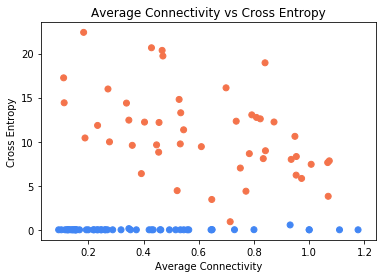

In [8]:
color_vals = ['#f4734b' if a == 0.0 else '#4286f4' for a in df['accuracy']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['cross_entropy']), 'Average Connectivity', 'Cross Entropy', color_vals=color_vals)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcca8897510>]], dtype=object)

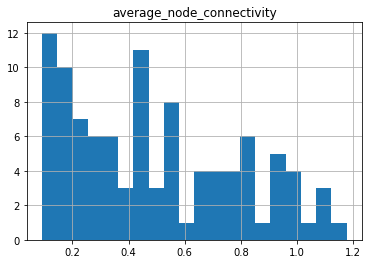

In [9]:
df.hist(column='average_node_connectivity', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcce47d74d0>]], dtype=object)

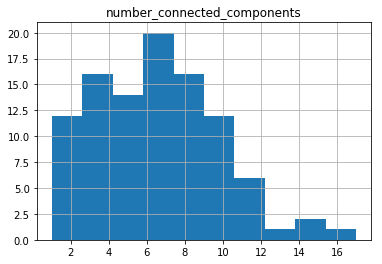

In [10]:
df.hist(column='number_connected_components')

In [11]:
df[df['accuracy'] == 0.0]

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
49,0.0,True,0.403332,6,12.223102,0_2_3.graphml,11,0,-0.162953
50,0.0,True,0.770854,0,4.380313,9_0_7.graphml,7,9,0.000114
51,0.0,True,0.544981,8,11.348094,3_4_30.graphml,6,3,0.079217
53,0.0,True,0.822777,6,12.592297,7_0_26.graphml,8,7,-0.417362
55,0.0,True,0.713712,8,0.916023,1_0_5.graphml,5,1,0.343047
56,0.0,True,0.735521,9,12.325178,5_3_45.graphml,5,5,-0.082550
57,0.0,True,0.521546,4,4.443521,2_4_38.graphml,4,2,-0.052923
58,0.0,True,0.698725,6,16.113117,7_2_26.graphml,6,7,-0.396443
59,0.0,True,0.808980,4,12.752671,1_3_46.graphml,6,1,-0.115719
60,0.0,True,0.187680,5,10.422480,0_4_28.graphml,10,0,-0.137259


In [12]:
df[df['adversary'] == True]

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
49,0.0,True,0.403332,6,12.223102,0_2_3.graphml,11,0,-0.162953
50,0.0,True,0.770854,0,4.380313,9_0_7.graphml,7,9,0.000114
51,0.0,True,0.544981,8,11.348094,3_4_30.graphml,6,3,0.079217
52,1.0,True,0.648208,7,0.021093,7_2_0.graphml,10,7,0.500694
53,0.0,True,0.822777,6,12.592297,7_0_26.graphml,8,7,-0.417362
54,1.0,True,0.930929,8,0.550846,1_8_5.graphml,5,8,0.419994
55,0.0,True,0.713712,8,0.916023,1_0_5.graphml,5,1,0.343047
56,0.0,True,0.735521,9,12.325178,5_3_45.graphml,5,5,-0.082550
57,0.0,True,0.521546,4,4.443521,2_4_38.graphml,4,2,-0.052923
58,0.0,True,0.698725,6,16.113117,7_2_26.graphml,6,7,-0.396443


('Coefficients: ', array([[ 3.5719272]]))
Mean squared error: 85.37
Variance score: -1.63
R^2: -1.63


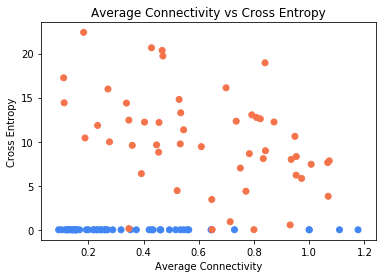

In [13]:
color_vals = ['#f4734b' if a else '#4286f4' for a in df['adversary']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['cross_entropy']), 'Average Connectivity', 'Cross Entropy', color_vals=color_vals)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fccca6ae4d0>]], dtype=object)

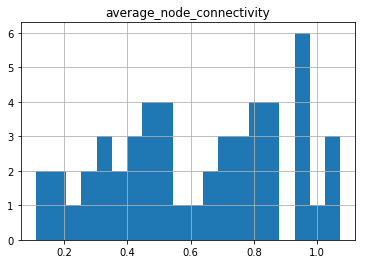

In [14]:
df[df['adversary'] == True].hist(column='average_node_connectivity', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd0c77cf90>]], dtype=object)

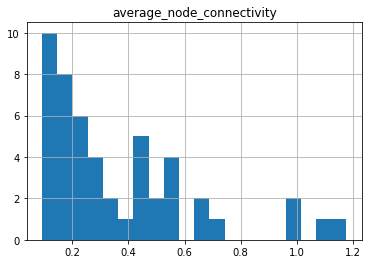

In [15]:
df[df['adversary'] == False].hist(column='average_node_connectivity', bins=20)

In [16]:
df[df['file'] == '0_15.graphml']

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
8,1.0,False,1.177047,0,0.0,0_15.graphml,1,0,0.850613
